In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [4]:
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [5]:
def split_data(x_data, y_data, num_clients=5):
    client_data = []
    num_items_per_client = x_data.shape[0] // num_clients
    for i in range(num_clients):
        start = i * num_items_per_client
        end = start + num_items_per_client
        client_x = x_data[start:end]
        client_y = y_data[start:end]
        if client_x.size > 0 and client_y.size > 0:
            client_data.append((client_x, client_y))
    return client_data

In [6]:
def federated_prox(clients, model_constructor, x_test, y_test, mu=0.01, rounds=10, epochs=3):
    global_model = model_constructor()
    accuracy_history = []

    for round_num in range(rounds):
        local_weights = []
        for client_x, client_y in clients:
            local_model = model_constructor()
            local_model.set_weights(global_model.get_weights())
            local_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            # Train local model
            local_model.fit(client_x, client_y, epochs=epochs, verbose=0)

            # Calculate proximal term loss
            prox_loss = 0
            for lw, gw in zip(local_model.get_weights(), global_model.get_weights()):
                prox_loss += mu * np.sum(np.square(lw - gw))

            # Add proximal term loss to local loss
            client_y_tensor = tf.convert_to_tensor(client_y, dtype=tf.int64)  # Ensure client_y is a Tensor
            with tf.GradientTape() as tape:
                logits = local_model(client_x, training=True)
                classification_loss = local_model.compiled_loss(y_true=client_y_tensor, y_pred=logits)
                total_loss = classification_loss + prox_loss
            gradients = tape.gradient(total_loss, local_model.trainable_variables)
            local_model.optimizer.apply_gradients(zip(gradients, local_model.trainable_variables))

            local_weights.append(local_model.get_weights())

        # Average local weights to update global model
        new_weights = [np.mean([w[i] for w in local_weights], axis=0) for i in range(len(local_weights[0]))]
        global_model.set_weights(new_weights)

        # Evaluate global model
        global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
        accuracy_history.append(accuracy)
        print(f'Round {round_num+1}, Test accuracy: {accuracy}')

    return global_model, accuracy_history

In [7]:
clients = split_data(x_train, y_train)
global_model, accuracy_history = federated_prox(clients, create_model, x_test, y_test)

Round 1, Test accuracy: 0.8514000177383423
Round 2, Test accuracy: 0.8853999972343445
Round 3, Test accuracy: 0.8968999981880188
Round 4, Test accuracy: 0.9039999842643738
Round 5, Test accuracy: 0.9089999794960022
Round 6, Test accuracy: 0.9100000262260437
Round 7, Test accuracy: 0.9124000072479248
Round 8, Test accuracy: 0.9139999747276306
Round 9, Test accuracy: 0.9140999913215637
Round 10, Test accuracy: 0.9168000221252441


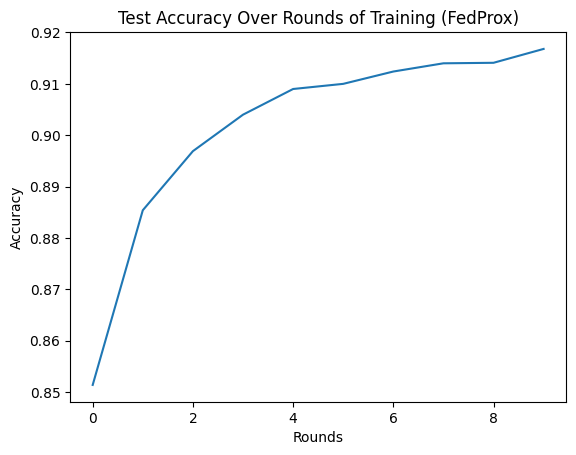

Final test accuracy: 0.9168000221252441


In [10]:
plt.plot(accuracy_history)
plt.title('Test Accuracy Over Rounds of Training (FedProx)')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.show()
print(f"Final test accuracy: {accuracy_history[-1]}")